In [1]:
%matplotlib inline

In [2]:
# Importing used Python libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import geodatasets
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from translate import Translator
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models, matutils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

C:\Users\yuri.todorov\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
#Show all columns when using head() and dtypes
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 100000)

In [4]:
# Function definitions
def get_nan_value_percentage(dataframe):
    nan_list = []
    nan_count = dataframe.isnull().sum()
    nan_percentage = (nan_count / len(dataframe)) * 100
    for column in dataframe.columns:
        nan_list.append(f"Column '{column}': NaN Count = {nan_count[column]}, NaN Percentage = {nan_percentage[column]:.2f}%")
    return nan_list

<a id='top'></a>

# Exploring Airbnb Listings in Amsterdam
### by Yuri Todorov

In this project we'll analyze data about AirBNB listings in Amsterdam, Netherlands. The data is taken from http://insideairbnb.com/ and is sourced from publicly available information from the Airbnb site. It has been scraped from the website on 05 June, 2023.<br><br>
<b>The data can be downloaded from my Dropbox as the files are too big to upload on SoftUni's website: </b>https://www.dropbox.com/scl/fo/eygt7zkscgvdhd3tpelfp/h?dl=0&rlkey=ajyja43859eervmv3r87gtzmi

## Abstract 

This project aims to predict the prices of Airbnb listings based on a comprehensive analysis of various features and factors that influence pricing. The project utilizes a dataset containing information about Airbnb listings, including property characteristics, location, amenities, host information, and guest reviews. The goal is to develop a regression model that accurately predicts listing prices, which can provide valuable insights to hosts, travelers, and the Airbnb platform itself. This prediction can aid hosts in setting competitive prices for their properties and assist travelers in making informed decisions when choosing accommodations. Additionally, the project contributes to the broader understanding of the factors that influence pricing in the short-term rental market.<br><br>
I've used three datasets:
 - <b>Listings</b>: A csv file containing a list of all properties available for renting in Amsterdam at the time of the scraping. It contains 75 features descibing them.
 - <b>Reviews</b>: A csv file with all comments left from the guests. I'll use it to try to justify and find the reason for low review scores in certain neighbourhoods.
 - <b>Neighbourhoods geo-dataset</b>: geojson file containing geometry data in the form of multipolygons as  which will help me draw the neighbourhoods and make analysis on the map.

## Contents 

* [1. Reading and tidying data. Preparing data for exploration](#read)
* [2. Columns Description](#legend) 
* [3. Analyze data quality and make feature selection, feature extraction and feature engineering based on the result](#nan)
    * [3.1. Listings dataset](#lst) 
    * [3.2. Reviews dataset](#rvw) 
    * [3.3. Neighbourhood geometry dataset](#geo) 
* [4. Geospatial analysis](#sa)
* [5. Analyze guests reviews](#com)
    * [5.1. Merge the two datasets](#mtd) 
    * [5.2. Create wordcloud for each neighbourhood](#cwen)
* [6. Heat-map of correlation](#heatmap)  
* [7. Prediction](#pred)

* [8. Key Accomplishments and conclusion](#con)


[TOP](#top)
<a id='read'></a>
## 1. Reading and tidying data. Preparing data for exploration

In [58]:
# Reading csv data
# The data is not included in the project folder and can be downloaded from my Dropbox: 
# https://www.dropbox.com/scl/fo/eygt7zkscgvdhd3tpelfp/h?dl=0&rlkey=ajyja43859eervmv3r87gtzmi
listings_df = pd.read_csv("data\\listings.csv")
reviews_df = pd.read_csv("data\\reviews.csv")

print('Number of AiBNB listings in Amsterdam: {}; Number of features: {}'.format(listings_df.shape[0], listings_df.shape[1]))
print('Number of reviews: {}; Number of features: {}'.format(reviews_df.shape[0], reviews_df.shape[1]))

# Reading geo data
neighbourhood_geometry_gdf = gpd.read_file("data\\neighbourhoods.geojson")

Number of AiBNB listings in Amsterdam: 7608; Number of features: 75
Number of reviews: 361374; Number of features: 6


In [8]:
# Exploring the data in listings_df
listings_df.sample(5)

id                                      listing_url  \
2868            26116424            https://www.airbnb.com/rooms/26116424   
6925  815204479024496474  https://www.airbnb.com/rooms/815204479024496474   
4007            40815993            https://www.airbnb.com/rooms/40815993   
6699  768624889023399491  https://www.airbnb.com/rooms/768624889023399491   
4280            44102257            https://www.airbnb.com/rooms/44102257   

           scrape_id last_scraped           source  \
2868  20230605223331   2023-06-06      city scrape   
6925  20230605223331   2023-06-06      city scrape   
4007  20230605223331   2023-06-06  previous scrape   
6699  20230605223331   2023-06-06      city scrape   
4280  20230605223331   2023-06-06  previous scrape   

                                                   name  \
2868  Boat in Amsterdam · ★4.94 · 2 bedrooms · 2 bed...   
6925  Rental unit in Amsterdam · ★New · 1 bedroom · ...   
4007  Rental unit in Amsterdam · ★5.0 · 1 bedroom · ...   
6699  Condo in Amsterdam · ★4.71 · 1 bedroom · 1 bed...   
4280  Condo in Amsterdam · ★4.67 · 1 bedroom · 1 bed...   

                                            description  \
2868  The area and facilities<br /><br />The yacht i...   
6925  In the great neighborhood Bos & Lommer (Amster...   
4007  Nice and cozy appartment at walking distance t...   
6699  Museum Square View is located in Amsterdam on ...   
4280  Delightful 1-bedroom apartment with a great te...   

                                  neighborhood_overview  \
2868  Motoryacht Flint is located on a unique and be...   
6925                                                NaN   
4007                                                NaN   
6699                                                NaN   
4280  Close to De Clercqstraat- with great restauran...   

                                            picture_url    host_id  \
2868  https://a0.muscache.com/pictures/79030e8b-dd23...  141677638   
6925  https://a0.muscache.com/pictures/miso/Hosting-...  196964857   
4007  https://a0.muscache.com/pictures/250e2b59-9062...  317405636   
6699  https://a0.muscache.com/pictures/miso/Hosting-...  489180306   
4280  https://a0.muscache.com/pictures/22a6927a-7c63...   15480229   

                                         host_url host_name  host_since  \
2868  https://www.airbnb.com/users/show/141677638      Gros  2017-07-21   
6925  https://www.airbnb.com/users/show/196964857     Karel  2018-06-21   
4007  https://www.airbnb.com/users/show/317405636     Jordi  2019-12-14   
6699  https://www.airbnb.com/users/show/489180306       Han  2022-11-26   
4280   https://www.airbnb.com/users/show/15480229     Pablo  2014-05-13   

               host_location  \
2868     Huizen, Netherlands   
6925  Amsterdam, Netherlands   
4007  Amsterdam, Netherlands   
6699                     NaN   
4280  Amsterdam, Netherlands   

                                             host_about  host_response_time  \
2868  My work is my passion, I have sailed my whole ...      within an hour   
6925                                                NaN  within a few hours   
4007                                                NaN        within a day   
6699                                                NaN      within an hour   
4280  Working and living in Amsterdam I offer my pla...      within an hour   

     host_response_rate host_acceptance_rate host_is_superhost  \
2868               100%                  97%                 t   
6925               100%                  14%                 f   
4007               100%                  76%                 f   
6699               100%                 100%                 f   
4280               100%                 100%                 f   

                                     host_thumbnail_url  \
2868  https://a0.muscache.com/im/pictures/user/8e9cd...   
6925  https://a0.muscache.com/im/pictures/user/User-...   
4007  https://a0.muscache.com/im/pictures/user/fe885...

In [10]:
# Exploring the data in reviews_df
reviews_df.sample(5)

listing_id                  id        date  reviewer_id reviewer_name  \
270346    28924243           540805870  2019-10-04    288181930         Ciara   
83332      2623099  695415864438508321  2022-08-17    467456096          Ruge   
10918       579851            33065601  2015-05-25     25504466      Jennifer   
261636    27464499  699757657306049813  2022-08-23    472320101       Florian   
45953      1162769           145096646  2017-04-17     52386474       Nicolas   

                                                 comments  
270346  Lovely place to stay lovely garden very helpfu...  
83332   Great location. Elianne is a wonderful host! V...  
10918   The boat house was amazing! Wasn't to far from...  
261636  Very clean, nice neighborhood, communication w...  
45953   Very nice and bright place near the city cente...

In [9]:
# Checking for duplicates: 
print(f"Number of duplicates in listings_df: {listings_df.duplicated().sum()}")
print(f"Number of duplicates in reviews_df: {reviews_df.duplicated().sum()}")

# Listing all columns
print(f"List of columns in listings_df: {listings_df.columns}")
print(f"List of columns in reviews_df: {reviews_df.columns}")

Number of duplicates in listings_df: 0
Number of duplicates in reviews_df: 0
List of columns in listings_df: Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_max

[TOP](#top)
<a id='legend'></a>
## 2. Columns Description
    
The columns descriptions can be found here: https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596

[TOP](#top)
<a id='nan'></a>
## 3. Analyze data quality and make feature selection, feature extraction and feature engineering based on the result

[TOP](#top)
<a id='lst'></a>
### 3.1. Listings dataset

In [11]:
# Analyze missing values in the listings dataset
get_nan_value_percentage(listings_df)

["Column 'id': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'listing_url': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'scrape_id': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'last_scraped': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'source': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'name': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'description': NaN Count = 2, NaN Percentage = 0.03%",
 "Column 'neighborhood_overview': NaN Count = 2770, NaN Percentage = 36.41%",
 "Column 'picture_url': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'host_id': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'host_url': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'host_name': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'host_since': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'host_location': NaN Count = 822, NaN Percentage = 10.80%",
 "Column 'host_about': NaN Count = 3209, NaN Percentage = 42.18%",
 "Column 'host_response_time': NaN Count = 2259, N

The column <b>neighbourhood</b> has 36.41% NaN values. It is a key feature that is needed for my analysis but I'll remove it because I will use the column neighbourhood_cleansed which is geocoded using the latitude and longitude against neighborhoods as defined by open or public digital shapefiles.<br><br>

I'll also remove the following features with relatively high percentage of NaN values as they are either insignificant for the analysis or it's not possible to derive them from another feature or use a mean value:<br>
<b>neighborhood_overview<br>
host_location<br>
host_about<br>
host_response_time<br>
host_response_rate<br>
host_acceptance_rate<br>
host_is_superhost<br>
host_neighbourhood<br>
neighbourhood_group_cleansed<br>
bathrooms<br>
beds<br>
calendar_updated<br>
first_review<br>
last_review<br>
review_scores_rating<br>
review_scores_accuracy<br>
review_scores_cleanliness<br>
review_scores_checkin<br>
review_scores_communication<br>
review_scores_location<br>
license</b><br><br>

<b>review_scores_value</b> and <b>reviews_per_month</b> are important features and NaN Percentage is relatively high. So I'll derive the missing 715 values assigning the mean review score per neighbourhood. I use mean and not median as it's more suitable because we have normal distribution (I'll show that later) and values are all in range.

The feature <b>price</b> includes the dollar sign ($) which I'll remove and convert it to a numeric type as the column will be used in a calculation.

I'll also exclude some metadata columns (<b>scrape_id, last_scraped, source, calendar_last_scraped</b>) and the URLs (<b>listing_url, picture_url, host_url, host_thumbnail_url, host_picture_url</b>) because they are irrelevant for the analysis.

In [12]:
# Calculate the mean review score per neighbourhood
mean_review_scores = listings_df.groupby('neighbourhood_cleansed')['review_scores_value'].mean()
mean_review_scores = mean_review_scores.round(2)

# Fill NaN values in 'review_scores_value' with mean values per neighbourhood
listings_df['review_scores_value'] = listings_df.apply(lambda row: mean_review_scores[row['neighbourhood_cleansed']]
                                     if pd.isna(row['review_scores_value']) else row['review_scores_value'], axis=1)

In [13]:
# Calculate the mean reviews per month by neighbourhood
mean_reviews_per_month = listings_df.groupby('neighbourhood_cleansed')['reviews_per_month'].mean()
mean_reviews_per_month = mean_reviews_per_month.round().astype(int)

# Fill NaN values in 'review_scores_value' with mean values per neighbourhood
listings_df['reviews_per_month'] = listings_df.apply(lambda row: mean_reviews_per_month[row['neighbourhood_cleansed']]
                                     if pd.isna(row['reviews_per_month']) else row['reviews_per_month'], axis=1)

In [14]:
# Remove the '$' symbol and convert the 'price' column to numeric
listings_df['price'] = listings_df['price'].str.replace('[^\d.]', '', regex=True).astype(float)

In [15]:
# Drop excluded columns
listings_df = listings_df.drop([
"scrape_id", 
"last_scraped", 
"source",
"calendar_last_scraped",
"neighbourhood",
"neighborhood_overview",
"host_location",
"host_about",
"host_response_time",
"host_response_rate",
"host_acceptance_rate",
"host_is_superhost",
"host_neighbourhood",
"neighbourhood_group_cleansed",
"bathrooms",
"beds",
"calendar_updated",
"first_review",
"last_review",
"review_scores_rating",
"review_scores_accuracy",
"review_scores_cleanliness",
"review_scores_checkin",
"review_scores_communication",
"review_scores_location",
"license",
"listing_url", 
"picture_url", 
"host_url", 
"host_thumbnail_url", 
"host_picture_url"
], axis=1)

In [16]:
listings_df.describe()
# Nothing outstanding observed

id       host_id  host_listings_count  \
count  7.608000e+03  7.608000e+03          7608.000000   
mean   2.328487e+17  1.032177e+08             2.676262   
std    3.489604e+17  1.393419e+08            15.422057   
min    2.818000e+03  3.159000e+03             1.000000   
25%    1.696009e+07  9.937172e+06             1.000000   
50%    3.822749e+07  3.501297e+07             1.000000   
75%    6.525168e+17  1.402245e+08             2.000000   
max    9.071470e+17  5.183111e+08           545.000000   

       host_total_listings_count     latitude    longitude  accommodates  \
count                7608.000000  7608.000000  7608.000000   7608.000000   
mean                    4.733964    52.366725     4.889936      2.904968   
std                    28.091864     0.017068     0.035059      1.353721   
min                     1.000000    52.290340     4.755710      1.000000   
25%                     1.000000    52.355890     4.866060      2.000000   
50%                     1.000000    52.365980     4.887770      2.000000   
75%                     3.000000    52.376470     4.908300      4.000000   
max                   741.000000    52.425120     5.026430     16.000000   

          bedrooms         price  minimum_nights  maximum_nights  \
count  6228.000000   7608.000000     7608.000000     7608.000000   
mean      1.656390    251.065589        4.914564      417.879732   
std       0.944984    263.170218       33.263777      483.031957   
min       1.000000      0.000000        1.000000        1.000000   
25%       1.000000    148.000000        2.000000       21.000000   
50%       1.000000    202.000000        3.000000       90.000000   
75%       2.000000    300.000000        4.000000     1125.000000   
max      17.000000  12000.000000     1001.000000     1825.000000   

       minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  \
count             7608.000000             7608.000000            7.608000e+03   
mean                 4.530626                5.223843            5.650596e+05   
std                 31.139916               31.387794            3.481617e+07   
min                  1.000000                1.000000            1.000000e+00   
25%                  2.000000                2.000000            2.100000e+01   
50%                  2.000000                3.000000            3.650000e+02   
75%                  4.000000                4.000000            1.125000e+03   
max               1001.000000             1001.000000            2.147484e+09   

       maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  \
count            7.608000e+03             7608.000000            7.608000e+03   
mean             5.650871e+05                4.876945            5.650776e+05   
std              3.481617e+07               31.267595            3.481617e+07   
min              1.000000e+00                1.000000            1.000000e+00   
25%              2.800000e+01                2.000000            2.800000e+01   
50%              3.650000e+02                3.000000            3.650000e+02   
75%              1.125000e+03                4.000000            1.125000e+03   
max              2.147484e+09             1001.000000            2.147484e+09   

       availability_30  availability_60  availability_90  availability_365  \
count      7608.000000      7608.000000      7608.000000       7608.000000   
mean          3.607124         8.913775        15.361067         79.586619   
std           6.529631        14.259669        22.536724        106.483001   
min           0.000000         0.000000         0.000000          0.000000   
25%           0.000000         0.000000         0.000000          0.000000   
50%           0.000000         2.000000         5.000000         21.000000   
75%           4.000000        11.000000        21.000000        145.000000   
max          30.000000        60.000000        90.000000        365.000000   

       number_of_reviews  number_

In [17]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7608 entries, 0 to 7607
Data columns (total 44 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7608 non-null   int64  
 1   name                                          7608 non-null   object 
 2   description                                   7606 non-null   object 
 3   host_id                                       7608 non-null   int64  
 4   host_name                                     7608 non-null   object 
 5   host_since                                    7608 non-null   object 
 6   host_listings_count                           7608 non-null   int64  
 7   host_total_listings_count                     7608 non-null   int64  
 8   host_verifications                            7608 non-null   object 
 9   host_has_profile_pic                          7608 non-null   o

Let's explore the unique values found in non-numeric features to check for extraordinary cases and outliers.

In [18]:
non_numeric_columns = listings_df.select_dtypes(exclude="number")

for col in non_numeric_columns.columns:
    print('Unique values for "{}"'.format(col))
    print(non_numeric_columns[col].unique())
    print('---------------------------------------------------------------------------------')

Unique values for "name"
['Rental unit in Amsterdam · ★4.76 · 1 bedroom · 1 bed · 1.5 baths'
 'Rental unit in Amsterdam · ★4.77 · 1 bedroom · 1 bed · 1 bath'
 'Rental unit in Amsterdam · ★4.86 · 3 bedrooms · 4 beds · 1.5 baths' ...
 'Bed and breakfast in Amsterdam · ★New · 1 bedroom · 2 beds · 1 private bath'
 'Rental unit in Amsterdam · ★New · 3 bedrooms · 3 beds · 3.5 baths'
 'Hotel in Amsterdam · ★New · Studio · 1 bed · 1 shared bath']
---------------------------------------------------------------------------------
Unique values for "description"
['Stay in one of the most vibrant neighborhoods of the city, with bars, restaurants, clubs, parks and just 2 minutes walk from the historic city centre, with its rings of canals. Enjoy being a 15 minutes bike or tram ride from central station, while having a very comfortable apartment for you and your friends, to which you can even walk back at night without all the fuss!<br /><br /><b>The space</b><br />Centrally placed beautiful apartmen

Let's explore some numeric unique values that could be important for the study

In [19]:
np.sort(listings_df["accommodates"].unique())
# No outliers or unusual values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 14, 16], dtype=int64)

In [20]:
np.sort(listings_df["price"].unique())

array([    0.,    18.,    30.,    31.,    35.,    36.,    39.,    40.,
          42.,    43.,    44.,    45.,    46.,    47.,    48.,    49.,
          50.,    51.,    52.,    53.,    54.,    55.,    56.,    57.,
          58.,    59.,    60.,    61.,    62.,    63.,    64.,    65.,
          66.,    67.,    68.,    69.,    70.,    71.,    72.,    73.,
          74.,    75.,    76.,    77.,    78.,    79.,    80.,    81.,
          82.,    83.,    84.,    85.,    86.,    87.,    88.,    89.,
          90.,    91.,    92.,    93.,    94.,    95.,    96.,    97.,
          98.,    99.,   100.,   101.,   102.,   103.,   104.,   105.,
         106.,   107.,   108.,   109.,   110.,   111.,   112.,   113.,
         114.,   115.,   116.,   117.,   118.,   119.,   120.,   121.,
         122.,   123.,   124.,   125.,   126.,   127.,   128.,   129.,
         130.,   131.,   132.,   133.,   134.,   135.,   136.,   137.,
         138.,   139.,   140.,   141.,   142.,   143.,   144.,   145.,
      

The prices 7900, 10000 and 12000 look high. Also the price 0 is interesting. I want to look what's behind these prices.

In [21]:
listings_df[listings_df["price"].isin([0, 7900, 10000, 12000])]

id                                               name  \
472    2474754  Rental unit in Amsterdam · ★4.71 · 1 bedroom ·...   
3867  39431135  Home in Amsterdam · ★4.89 · 3 bedrooms · 3 bed...   
4121  42431273                Hotel in Amsterdam · ★4.34 · Studio   
4221  43600284  Serviced apartment in Amsterdam · 1 bedroom · ...   

                                            description    host_id  \
472   Nice renovated appartment in the center of the...   10428722   
3867  Uniquely designed house with 2 bedrooms, a sma...    3884675   
4121                                                NaN  309119467   
4221  Prinsenhuis is located in the hart of the UN c...   93743075   

       host_name  host_since  host_listings_count  host_total_listings_count  \
472         Yaap  2013-12-04                    1                          1   
3867      Devran  2012-10-16                    1                          3   
4121  Hotel Abba  2019-11-13                    5                          9   
4221      Kelsey  2016-09-05                    2                          2   

                    host_verifications host_has_profile_pic  \
472                 ['email', 'phone']                    t   
3867  ['email', 'phone', 'work_email']                    t   
4121                ['email', 'phone']                    t   
4221  ['email', 'phone', 'work_email']                    t   

     host_identity_verified  neighbourhood_cleansed  latitude  longitude  \
472                       t            Centrum-West  52.37914    4.88491   
3867                      f            Centrum-West  52.38264    4.88572   
4121                      t  De Baarsjes - Oud-West  52.36279    4.87458   
4221                      t            Centrum-Oost  52.36331    4.89307   

                           property_type        room_type  accommodates  \
472                   Entire rental unit  Entire home/apt             2   
3867                         Entire home  Entire home/apt             4   
4121                       Room in hotel       Hotel room             3   
4221  Private room in serviced apartment     Private room             4   

      bathrooms_text  bedrooms  \
472           1 bath       1.0   
3867       2.5 baths       3.0   
4121             NaN       NaN   
4221  1 private bath       1.0   

                                              amenities    price  \
472   ["Iron", "Smoke alarm", "Hair dryer", "Coffee ...  10000.0   
3867  ["Iron", "Backyard", "Portable fans", "Smoke a...   7900.0   
4121  ["Iron", "Free wifi", "Toiletries", "Complimen...      0.0   
4221  ["Iron", "Lockbox", "Smoke alarm", "Hair dryer...  12000.0   

      minimum_nights  maximum_nights  minimum_minimum_nights  \
472                5            1125                       5   
3867               3            1125                       3   
4121               1             365                       1   
4221               1              14                       1   

      maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
472                        5                    1125                    1125   
3867                       3                    1125                    1125   
4121                       1                     365                     365   
4221                       1                      14                      14   

      minimum_nights_avg_ntm  maximum_nights_avg_ntm has_availability  \
472                      5.0                  1125.0                t   
3867                     3.0                  1125.0                t   
4121                     1.0                   365.0                f   
4221                     1.0                    14.0                t   

      availability_30  availability_60  availability_90  availability_365  \
472                14               30               38               313   
3867                0                0                0                 0   
4121      

The expensive ones are real listings - luxary apartmanets and whole houses and villas. <br>
The zero-priced one is not listed anymore and doesn't have a licence in the dataset. So I'll remove it from the dataframe.<br><br>I'll also split the prices into categories (creating the new feature <b>price_category</b>) and plot them on a bar chart to see where the majority of the listings fall into.

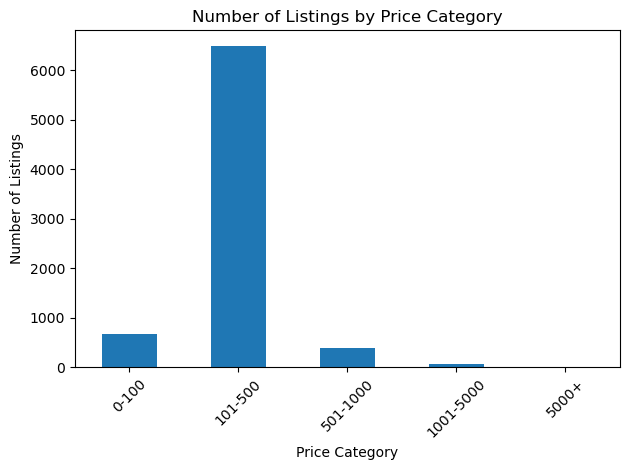

In [23]:
# Remove the 0-prices property
listings_df = listings_df[listings_df['price'] != 0]

# Define price categories (bins)
bins = [0, 100, 500, 1000, 5000, float('inf')]
labels = ['0-100', '101-500', '501-1000', '1001-5000', '5000+']

# Create a new column 'price_category' based on the bins
listings_df['price_category'] = pd.cut(listings_df['price'], bins=bins, labels=labels, right=False)

# Group by 'price_category' and calculate the count of listings
count_by_category = listings_df.groupby('price_category').size()

# Plot the count of listings by price category
count_by_category.plot(kind='bar')
plt.xlabel('Price Category')
plt.ylabel('Number of Listings')
plt.title('Number of Listings by Price Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
np.sort(listings_df["number_of_reviews"].unique()) # No outliers here

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  145,  146,  147,  148,  149,  1

In [27]:
listings_df[(listings_df["review_scores_value"]) < 1 | (listings_df["review_scores_value"] > 5)] # No outliers here

Empty DataFrame
Columns: [id, name, description, host_id, host_name, host_since, host_listings_count, host_total_listings_count, host_verifications, host_has_profile_pic, host_identity_verified, neighbourhood_cleansed, latitude, longitude, property_type, room_type, accommodates, bathrooms_text, bedrooms, amenities, price, minimum_nights, maximum_nights, minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm, has_availability, availability_30, availability_60, availability_90, availability_365, number_of_reviews, number_of_reviews_ltm, number_of_reviews_l30d, review_scores_value, instant_bookable, calculated_host_listings_count, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms, reviews_per_month, price_category]
Index: []

[TOP](#top)
<a id='rvw'></a>
### 3.2. Reviews dataset

In [28]:
# Analyze missing values in the reviews dataset
get_nan_value_percentage(reviews_df) # No missing values

["Column 'listing_id': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'id': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'date': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'reviewer_id': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'reviewer_name': NaN Count = 0, NaN Percentage = 0.00%",
 "Column 'comments': NaN Count = 13, NaN Percentage = 0.00%"]

My intention is to merge the reviews_df with listings_df and to analyze the comments column. So I'll drop the not needed columns

In [31]:
reviews_df = reviews_df.drop(["id", "date", "reviewer_id", "reviewer_name"], axis=1)

In [32]:
reviews_df.info() # No-null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361374 entries, 0 to 361373
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   listing_id  361374 non-null  int64 
 1   comments    361361 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.5+ MB


[TOP](#top)<a id='geo'></a>
### 3.3. Neighbourhood geometry dataset

In [33]:
neighbourhood_geometry_gdf.head(100)

neighbourhood  neighbourhood_group  \
0                             Bijlmer-Oost                  NaN   
1                               Noord-Oost                  NaN   
2                               Noord-West                  NaN   
3                                Oud-Noord                  NaN   
4                 IJburg - Zeeburgereiland                  NaN   
5                             Centrum-West                  NaN   
6   Oostelijk Havengebied - Indische Buurt                  NaN   
7                             Centrum-Oost                  NaN   
8                                 Oud-Oost                  NaN   
9                          Watergraafsmeer                  NaN   
10                   Gaasperdam - Driemond                  NaN   
11                              Westerpark                  NaN   
12                         Bijlmer-Centrum                  NaN   
13                 De Pijp - Rivierenbuurt                  NaN   
14                                    Zuid                  NaN   
15                  Buitenveldert - Zuidas                  NaN   
16                  De Baarsjes - Oud-West                  NaN   
17                           Bos en Lommer                  NaN   
18                 Geuzenveld - Slotermeer                  NaN   
19                             Slotervaart                  NaN   
20                                  Osdorp                  NaN   
21                  De Aker - Nieuw Sloten                  NaN   

                                             geometry  
0   MULTIPOLYGON Z (((4.99167 52.32444 43.06929, 4...  
1   MULTIPOLYGON Z (((5.07916 52.38865 42.95663, 5...  
2   MULTIPOLYGON Z (((4.93072 52.41161 42.91539, 4...  
3   MULTIPOLYGON Z (((4.95242 52.38983 42.95411, 4...  
4   MULTIPOLYGON Z (((5.03906 52.35458 43.01664, 5...  
5   MULTIPOLYGON Z (((4.90640 52.38004 42.97078, 4...  
6   MULTIPOLYGON Z (((4.96131 52.35913 43.00823, 4...  
7   MULTIPOLYGON Z (((4.93297 52.37041 42.98810, 4...  
8   MULTIPOLYGON Z (((4.93743 52.35774 43.01043, 4...  
9   MULTIPOLYGON Z (((4.96971 52.35636 43.01317, 4...  
10  MULTIPOLYGON Z (((5.02154 52.30246 43.10781, 5...  
11  MULTIPOLYGON Z (((4.89508 52.38869 42.95535, 4...  
12  MULTIPOLYGON Z (((4.97184 52.28436 43.13905, 4...  
13  MULTIPOLYGON Z (((4.91498 52.34215 43.03750, 4...  
14  MULTIPOLYGON Z (((4.88738 52.36023 43.00532, 4...  
15  MULTIPOLYGON Z (((4.89907 52.33044 43.05777, 4...  
16  MULTIPOLYGON Z (((4.88209 52.36205 43.00203, 4...  
17  MULTIPOLYGON Z (((4.86496 52.38896 42.95433, 4...  
18  MULTIPOLYGON Z (((4.83945 52.38404 42.96248, 4...  
19  MULTIPOLYGON Z (((4.85049 52.36424 42.99757, 4...  
20  MULTIPOLYGON Z (((4.82043 52.35174 43.01884, 4...  
21  MULTIPOLYGON Z (((4.84713 52.33690 43.04548, 4...

I can see that the neighbourhood_group feature have only NaN values so I'll drop it.

In [34]:
neighbourhood_geometry_gdf = neighbourhood_geometry_gdf.drop(["neighbourhood_group"], axis=1)

[TOP](#top)
<a id='sa'></a>
## 4. Geospatial analysis

In [36]:
# Calculate the price per person for each apartment
listings_df['price_per_person'] = listings_df['price'] / listings_df['accommodates']

# Group by 'neighbourhood_cleansed' and calculate the mean price per person and mean review_scores_value
price_per_person_by_neighbourhood_df = listings_df.groupby('neighbourhood_cleansed').agg({'price_per_person': 'mean', 'review_scores_value': 'mean'})

# Reset index to make neighbourhood_cleansed a regular column
price_per_person_by_neighbourhood_df = price_per_person_by_neighbourhood_df.reset_index()

price_per_person_by_neighbourhood_df.head(5)

neighbourhood_cleansed  price_per_person  review_scores_value
0         Bijlmer-Centrum         46.750000             4.532826
1            Bijlmer-Oost         58.011508             4.691667
2           Bos en Lommer         72.880999             4.647539
3  Buitenveldert - Zuidas         71.291593             4.677407
4            Centrum-Oost        109.972429             4.614589

In [38]:
merged_df = pd.merge(price_per_person_by_neighbourhood_df, neighbourhood_geometry_gdf, left_on='neighbourhood_cleansed', right_on='neighbourhood', how='left')
bed_price_per_neighbourhood_geo_df = merged_df.drop(["neighbourhood_cleansed"], axis=1)

In [39]:
bed_price_per_neighbourhood_geo_df.head(100)

price_per_person  review_scores_value  \
0          46.750000             4.532826   
1          58.011508             4.691667   
2          72.880999             4.647539   
3          71.291593             4.677407   
4         109.972429             4.614589   
5         114.503563             4.620753   
6          78.906586             4.677903   
7          93.185361             4.631930   
8          97.669785             4.643819   
9          47.280612             4.573265   
10         56.883243             4.555543   
11         62.859151             4.692622   
12         53.550278             4.666167   
13         56.718416             4.650859   
14         75.093124             4.682762   
15         61.977273             4.626364   
16         76.254189             4.592052   
17         87.884294             4.657273   
18         70.866667             4.648792   
19         73.904942             4.646320   
20         89.496647             4.658265   
21         98.982628             4.645843   

                             neighbourhood  \
0                          Bijlmer-Centrum   
1                             Bijlmer-Oost   
2                            Bos en Lommer   
3                   Buitenveldert - Zuidas   
4                             Centrum-Oost   
5                             Centrum-West   
6                   De Aker - Nieuw Sloten   
7                   De Baarsjes - Oud-West   
8                  De Pijp - Rivierenbuurt   
9                    Gaasperdam - Driemond   
10                 Geuzenveld - Slotermeer   
11                IJburg - Zeeburgereiland   
12                              Noord-Oost   
13                              Noord-West   
14  Oostelijk Havengebied - Indische Buurt   
15                                  Osdorp   
16                               Oud-Noord   
17                                Oud-Oost   
18                             Slotervaart   
19                         Watergraafsmeer   
20                              Westerpark   
21                                    Zuid   

                                             geometry  
0   MULTIPOLYGON Z (((4.97184 52.28436 43.13905, 4...  
1   MULTIPOLYGON Z (((4.99167 52.32444 43.06929, 4...  
2   MULTIPOLYGON Z (((4.86496 52.38896 42.95433, 4...  
3   MULTIPOLYGON Z (((4.89907 52.33044 43.05777, 4...  
4   MULTIPOLYGON Z (((4.93297 52.37041 42.98810, 4...  
5   MULTIPOLYGON Z (((4.90640 52.38004 42.97078, 4...  
6   MULTIPOLYGON Z (((4.84713 52.33690 43.04548, 4...  
7   MULTIPOLYGON Z (((4.88209 52.36205 43.00203, 4...  
8   MULTIPOLYGON Z (((4.91498 52.34215 43.03750, 4...  
9   MULTIPOLYGON Z (((5.02154 52.30246 43.10781, 5...  
10  MULTIPOLYGON Z (((4.83945 52.38404 42.96248, 4...  
11  MULTIPOLYGON Z (((5.03906 52.35458 43.01664, 5...  
12  MULTIPOLYGON Z (((5.07916 52.38865 42.95663, 5...  
13  MULTIPOLYGON Z (((4.93072 52.41161 42.91539, 4...  
14  MULTIPOLYGON Z (((4.96131 52.35913 43.00823, 4...  
15  MULTIPOLYGON Z (((4.82043 52.35174 43.01884, 4...  
16  MULTIPOLYGON Z (((4.95242 52.38983 42.95411, 4...  
17  MULTIPOLYGON Z (((4.93743 52.35774 43.01043, 4...  
18  MULTIPOLYGON Z (((4.85049 52.36424 42.99757, 4...  
19  MULTIPOLYGON Z (((4.96971 52.35636 43.01317, 4...  
20  MULTIPOLYGON Z (((4.89508 52.38869 42.95535, 4...  
21  MULTIPOLYGON Z (((4.88738 52.36023 43.00532, 4...

In [40]:
# Transform to GeoDataframe
gdf = gpd.GeoDataFrame(
    bed_price_per_neighbourhood_geo_df, geometry=bed_price_per_neighbourhood_geo_df.geometry, crs="EPSG:4326"
)

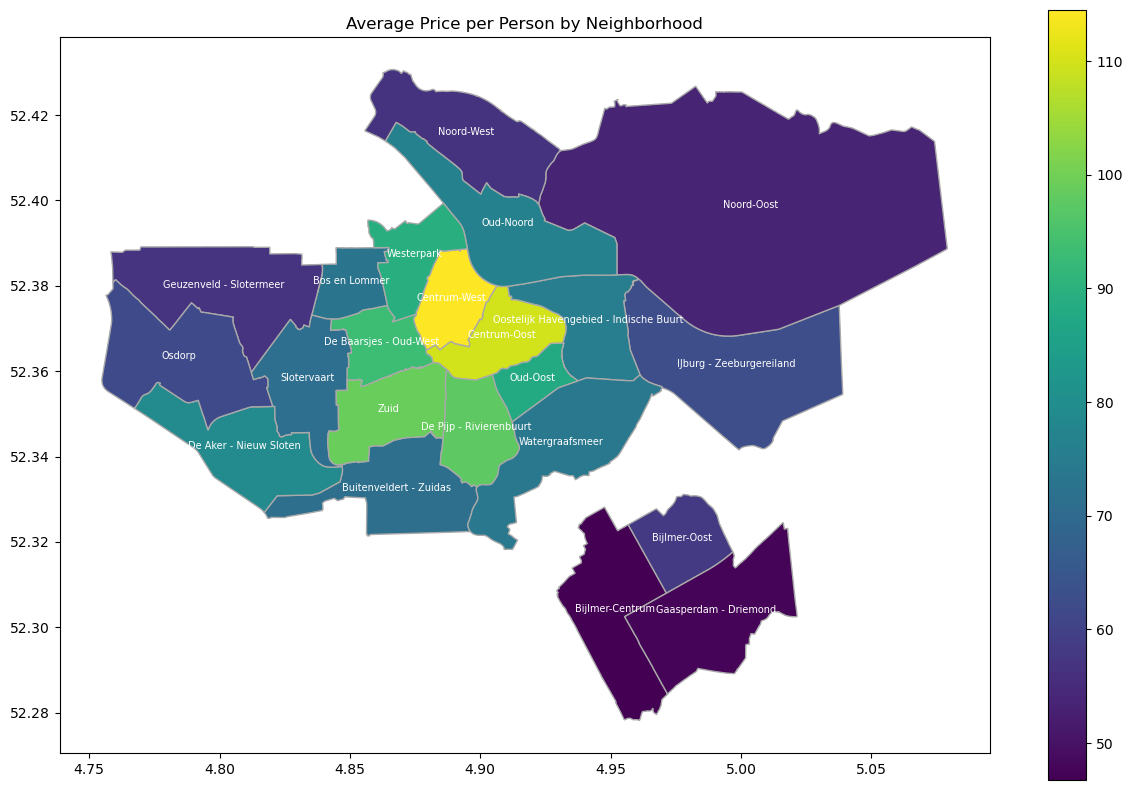

In [41]:
plt_prices = gdf.plot(column = "price_per_person", figsize=(15, 10), edgecolor='darkgrey', legend=True)

for idx, row in gdf.iterrows():
    label = row['neighbourhood']
    plt_prices.annotate(label, (row.geometry.centroid.x, row.geometry.centroid.y), color='white', fontsize=7, ha='center')

plt.title("Average Price per Person by Neighborhood")
plt.show()


We can see that central locations and south-eastern have higher prices. It's expected - those are the locations closer to museums, concert venues, sports halls and other attractions. It's interesting why an area also close to the center - to the north-east - is not as expensive as south-eastern area from the center. That's because there's a big channel there splitting the Noord neighbourhood which is not very easily accessible.<br><br>
Let's explore the Average Review Scores by Neighborhood to see if we'll spot anything interesting.

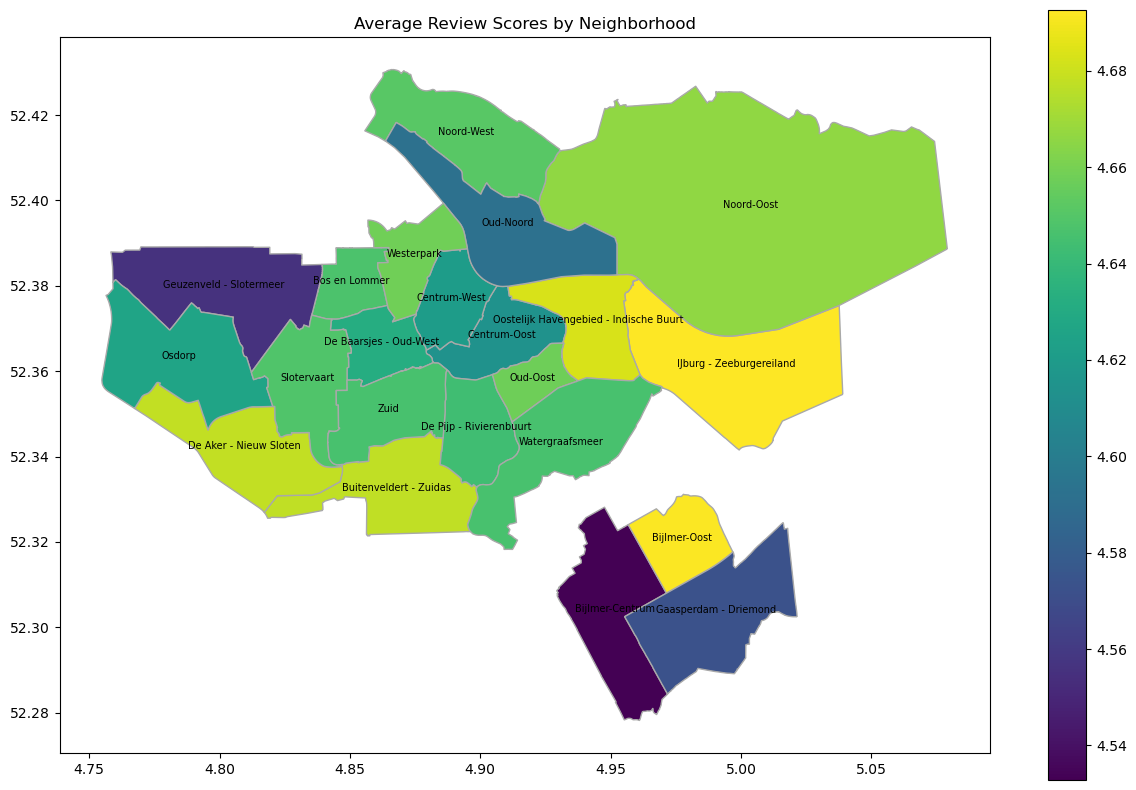

In [42]:
plt_reviews = gdf.plot(column = "review_scores_value", figsize=(15, 10), edgecolor='darkgrey', legend=True)

for idx, row in gdf.iterrows():
    label = row['neighbourhood']
    plt_reviews.annotate(label, (row.geometry.centroid.x, row.geometry.centroid.y), color='black', fontsize=7, ha='center')

plt.title("Average Review Scores by Neighborhood")
plt.show()

I realize that this analysis could be influenced by fewer number of listings/persons it could accomodate for certain neighbourhoods. For that reason I'll calculate a <b>weighted mean review score</b> to see if this will balance the picture.

In [45]:
# Group by 'neighbourhood_cleansed' and calculate weighted mean review score
grouped = listings_df.groupby('neighbourhood_cleansed').apply(lambda x: (x['review_scores_value'] * x['accommodates']).sum() / x['accommodates'].sum())

# Reset index to make 'neighbourhood_cleansed' a regular column
grouped = grouped.reset_index()

# Rename columns for clarity
grouped.columns = ['neighbourhood', 'weighted_mean_review_score']

print(grouped)

                             neighbourhood  weighted_mean_review_score
0                          Bijlmer-Centrum                    4.561571
1                             Bijlmer-Oost                    4.691124
2                            Bos en Lommer                    4.628807
3                   Buitenveldert - Zuidas                    4.668640
4                             Centrum-Oost                    4.605022
5                             Centrum-West                    4.615073
6                   De Aker - Nieuw Sloten                    4.694082
7                   De Baarsjes - Oud-West                    4.629824
8                  De Pijp - Rivierenbuurt                    4.641358
9                    Gaasperdam - Driemond                    4.588261
10                 Geuzenveld - Slotermeer                    4.540257
11                IJburg - Zeeburgereiland                    4.671091
12                              Noord-Oost                    4.668494
13    

In [47]:
weighted_mean_review_score_geo_df = pd.merge(grouped, neighbourhood_geometry_gdf, left_on='neighbourhood', right_on='neighbourhood', how='left')
weighted_mean_review_score_geo_df.head(4)

neighbourhood  weighted_mean_review_score  \
0         Bijlmer-Centrum                    4.561571   
1            Bijlmer-Oost                    4.691124   
2           Bos en Lommer                    4.628807   
3  Buitenveldert - Zuidas                    4.668640   

                                            geometry  
0  MULTIPOLYGON Z (((4.97184 52.28436 43.13905, 4...  
1  MULTIPOLYGON Z (((4.99167 52.32444 43.06929, 4...  
2  MULTIPOLYGON Z (((4.86496 52.38896 42.95433, 4...  
3  MULTIPOLYGON Z (((4.89907 52.33044 43.05777, 4...

In [48]:
# Transform to GeoDataframe
gdf_weighted_mean_reviews = gpd.GeoDataFrame(
    weighted_mean_review_score_geo_df, geometry=weighted_mean_review_score_geo_df.geometry, crs="EPSG:4326"
)

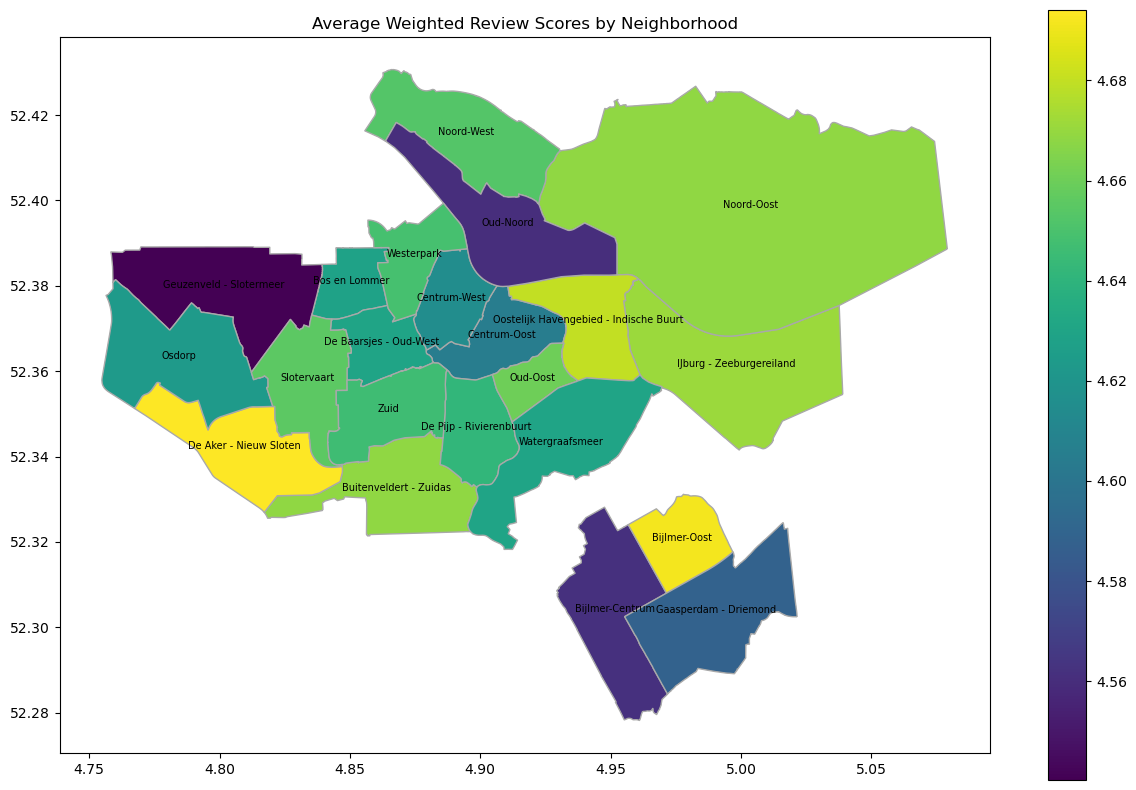

In [49]:
plt_reviews = gdf_weighted_mean_reviews.plot(column = "weighted_mean_review_score", figsize=(15, 10), edgecolor='darkgrey', legend=True)

for idx, row in gdf.iterrows():
    label = row['neighbourhood']
    plt_reviews.annotate(label, (row.geometry.centroid.x, row.geometry.centroid.y), color='black', fontsize=7, ha='center')

plt.title("Average Weighted Review Scores by Neighborhood")
plt.show()

We can see that using with weighted reviews scores gives us slightly more evenly distributed review scores. The visual inspection reveals two outliers. First one is De Aker - Nieuw Sloten having very low scores. And the three neighbourhoods in south-eastern Amsterdam that stand out with higher scores than anywhere else.<br><br>
I will try to explain why is that by analyzing the comments guests have left for the places in those neighbourhoods. I'll do that in the next section.

[TOP](#top)
<a id='com'></a>
## 5. Analyze guests reviews
My aim is to group the comments by neighbourhood and create and visualize wordclouds for each of them. Then inspect the wordcloud for De Aker - Nieuw Sloten to see if any particular reason for the low scores would come out. I realize that this a very basic text processing technique but it could prove to be enough for our purpose.<br><br>I know from the section "Analyze data quality and make feature selection based on the result" that not all comments are in English. I'll use the <b>translate</b> library to translate to English. For the wordcloud I'll use the <b>wordcloud</b> library.


[TOP](#top)
<a id='mtd'></a>
### 5.1. Merge the two datasets

In [50]:
# Join the listings with reviews and group by neighbourhood.
listings_reviews_df = pd.merge(reviews_df, listings_df, left_on='listing_id', right_on='id', how='left')
listings_reviews_df = listings_reviews_df[["neighbourhood_cleansed", "comments"]]
listings_reviews_df["comments"] = listings_reviews_df["comments"].astype(str)

# Group by neighborhood and aggregate comments
listings_reviews_df = listings_reviews_df.groupby('neighbourhood_cleansed')['comments'].apply(lambda x: ' '.join(x)).reset_index()

listings_reviews_df.sample(22)

neighbourhood_cleansed  \
16                               Oud-Noord   
21                                    Zuid   
5                             Centrum-West   
2                            Bos en Lommer   
0                          Bijlmer-Centrum   
20                              Westerpark   
11                IJburg - Zeeburgereiland   
6                   De Aker - Nieuw Sloten   
7                   De Baarsjes - Oud-West   
1                             Bijlmer-Oost   
12                              Noord-Oost   
8                  De Pijp - Rivierenbuurt   
13                              Noord-West   
10                 Geuzenveld - Slotermeer   
4                             Centrum-Oost   
14  Oostelijk Havengebied - Indische Buurt   
3                   Buitenveldert - Zuidas   
17                                Oud-Oost   
19                         Watergraafsmeer   
9                    Gaasperdam - Driemond   
15                                  Osdorp   
18                             Slotervaart   

                                             comments  
16  A stone's throw away from the city centre(abou...  
21  Great city! Perfect place to stay! Would stay ...  
5   Wonderful hosts,friendly and helpful. Great lo...  
2   Everything was great! The apartment is beautif...  
0   길에서 많이 보이는 전형적인 네덜란드식 가정집입니다. 암스테르담이 처음인 분이 버스...  
20  Wunderbares kleines "Zimmer" in einem Hausboot...  
11  My girlfriend and me enjoyed the stay in Micha...  
6   This houseboat is superb and we would recommen...  
7   Nicole was a very nice hostess, and the appart...  
1   Andreas place is very beautiful, nice style, c...  
12  The host canceled this reservation 7 days befo...  
8   I stayed with Mr. Hendrik from September 9, 20...  
13  My stay at Fred´s B&B exceeded all expectation...  
10  I've stayed in Nadia's house for 3 nights. She...  
4   The location of Sasha's B&B makes it ideal for...  
14  Daniel is really cool. The place was nice and ...  
3   We really enjoyed our stay in Sophia's apartme...  
17  Our stay with Maria in September was great! Th...  
19  Myself and three friends stayed at Dimphy's ap...  
9   Truus is een oprechte, (h)eerlijke, gastvrouw....  
15  André is a very friendly host. The room was ex...  
18  Alex is a nice guy with a lovely flat. When we...

[TOP](#top)
<a id='cwen'></a>
### 5.2. Create wordcloud for each neighbourhood

In [51]:
# I've identified in advance that the HTML tag "br" appears to be the most used "word" so I'll add it to the list of stopwords 
stop_words = ["br"] + list(STOPWORDS)

# Create a Translator object
translator = Translator(to_lang="en")

# Group data by neighborhood and create word clouds
wordclouds = {}
for neighborhood, group in listings_reviews_df.groupby('neighbourhood_cleansed'):
    text = ' '.join(group['comments'])
    translated_text = translator.translate(text)
    wordcloud = WordCloud(max_words=150, stopwords = stop_words,width=400, height=300, background_color='white').generate(translated_text)
    wordclouds[neighborhood] = wordcloud

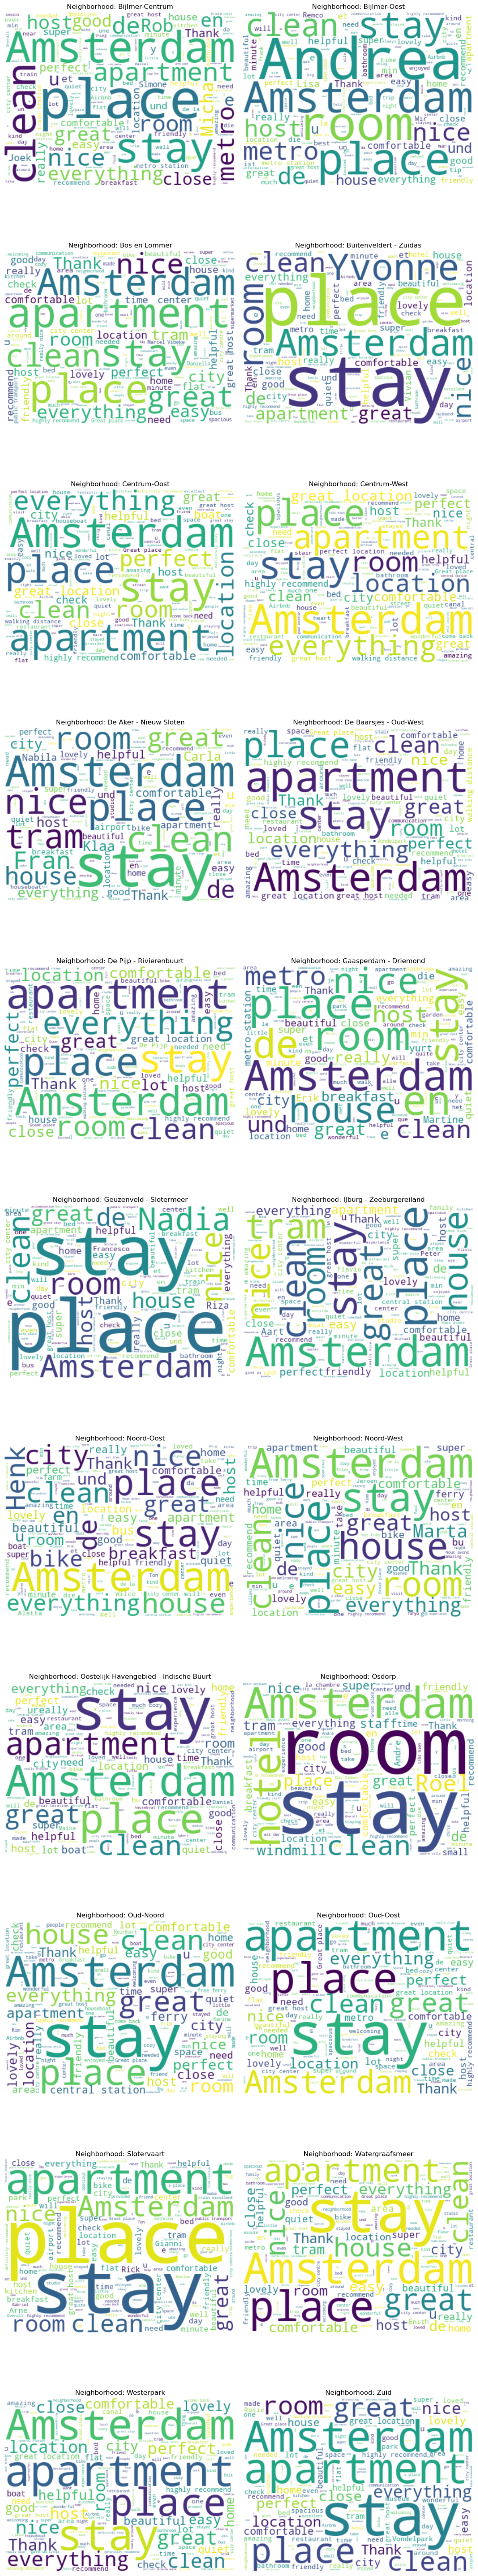

In [52]:
# Calculate the number of rows needed
num_rows = (len(wordclouds) + 1) // 2  # Round up to the nearest integer

# Create a subplot grid for each pair of word clouds
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6*num_rows))

# Plot word clouds for each neighborhood pair
for i, (neighborhood, wordcloud) in enumerate(wordclouds.items()):
    row = i // 2
    col = i % 2
    axes[row, col].imshow(wordcloud, interpolation='bilinear')
    axes[row, col].set_title(f'Neighborhood: {neighborhood}')
    axes[row, col].axis('off')

# Hide any remaining empty subplots
for i in range(len(wordclouds), num_rows * 2):
    row = i // 2
    col = i % 2
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


Not very useful information can be extracted from the guests' comments useing worclouds - there are a lot of repeating cliche words. The reason could be psychological - most people want to be polite ans don't feel comfortable sharing negative feedback. Other reason could be that wordclouds are really not best suited for my purpose because don't provide any context or deeper understanding of the words and phrases being used.

[TOP](#top)
<a id='heatmap'></a>
## 6. Heat-map of correlation
Correlation heatmaps can be used to find potential relationships between features and to understand the strength of these relationships. In addition, correlation plots can be used to identify outliers and to detect linear and nonlinear relationships.<br><br>First we have to convert the values in the features to int. I will use OrdinalEncoder.<br>

In [53]:
# Make a dataframe with numerical values
heatmap_data = listings_df.copy()
enc = OrdinalEncoder(handle_unknown="error")
heatmap_data = enc.fit_transform(heatmap_data)
heatmap_data = pd.DataFrame(heatmap_data, columns= enc.feature_names_in_)

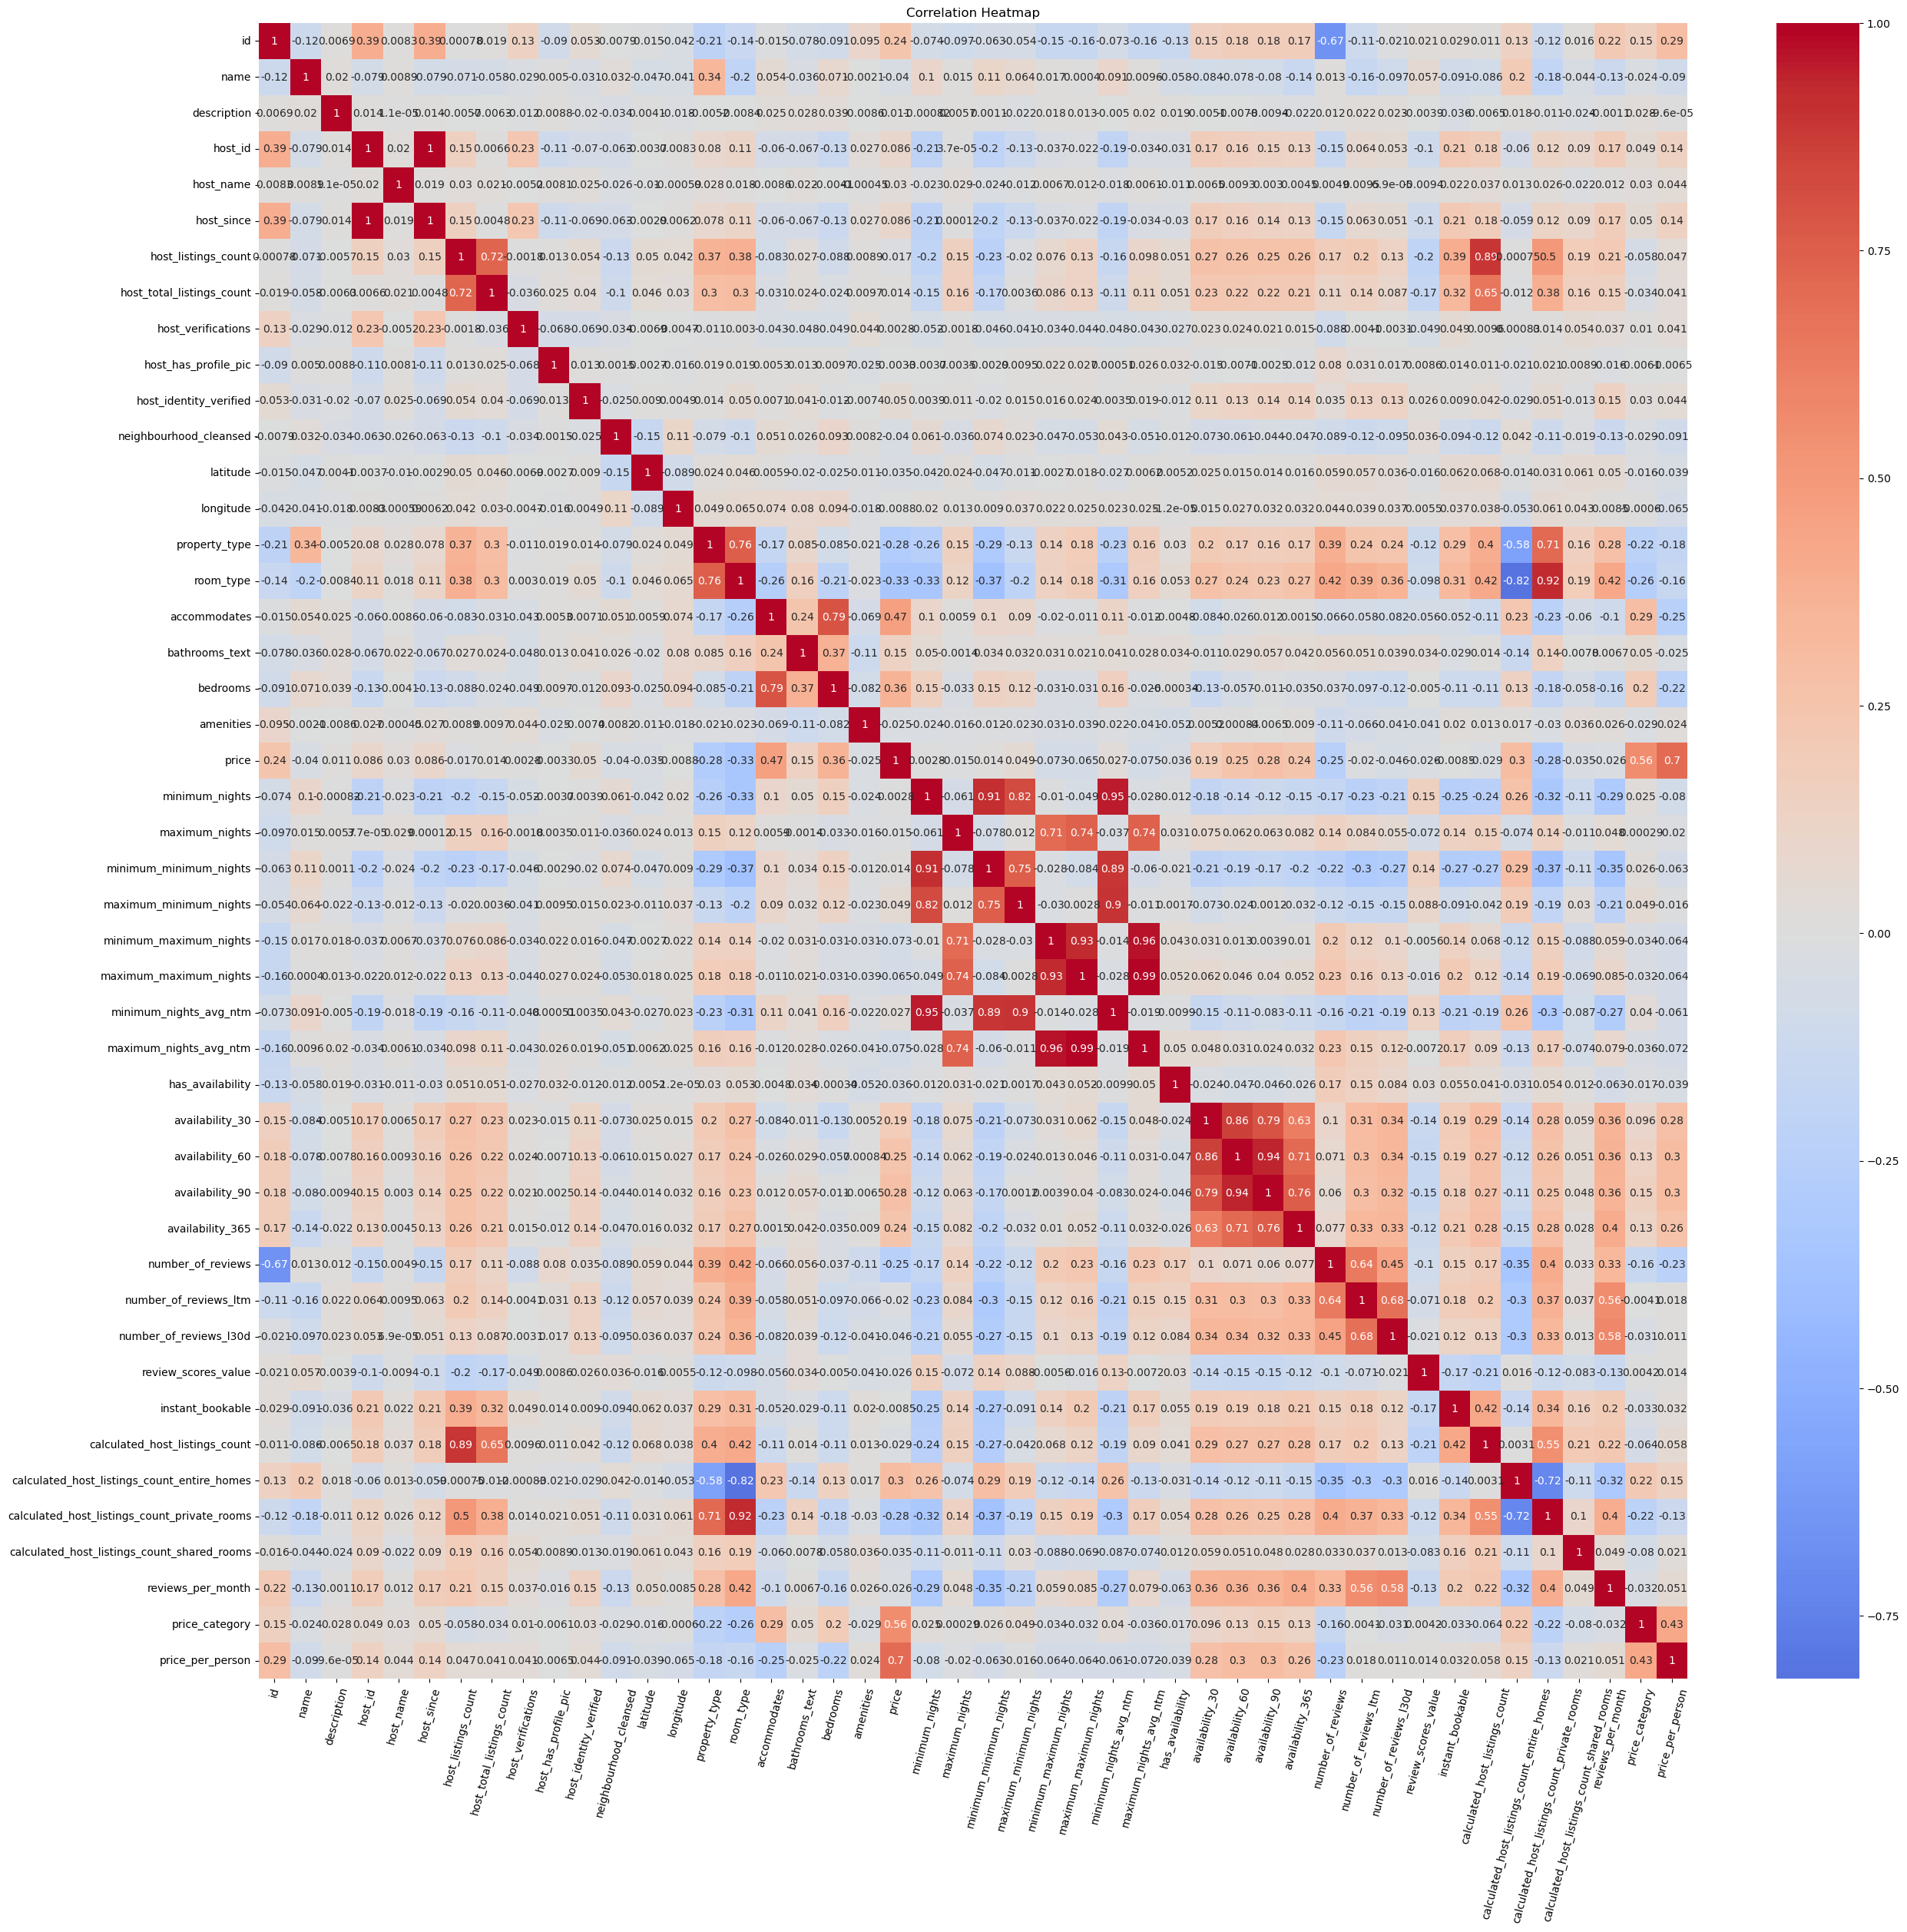

In [54]:
# Calculate the correlation matrix
correlation_matrix = heatmap_data.corr(method= 'spearman' , numeric_only = True)

# Create a heatmap
plt.figure(figsize=(30, 28))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.xticks(rotation = 75)
plt.show()

It's interesting to see how low the correlation is between <b>price</b> and <b>property_type</b> and <b>room_type</b>. However the correlation is stronger between <b>price</b> and how may people it <b>accomodates</b>, <b>bedrooms</b> and <b>amenities</b>. Let's visualize it.

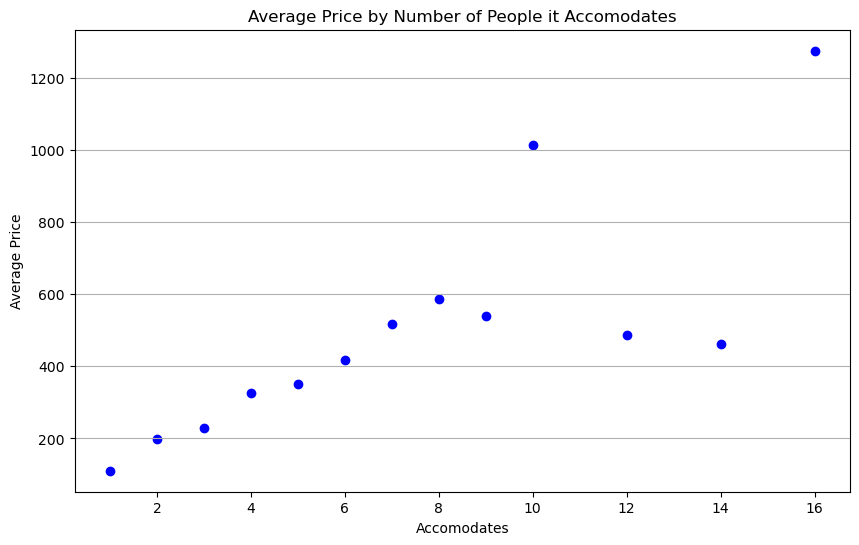

In [55]:
average_price = listings_df.groupby('accommodates')['price'].mean()

plt.figure(figsize=(10, 6))
plt.scatter(average_price.index, average_price.values, color='blue')
plt.title('Average Price by Number of People it Accomodates')
plt.xlabel('Accomodates')
plt.ylabel('Average Price')
plt.grid(axis='y')
plt.show()

[TOP](#top)
<a id='pred'></a>
## 7. Prediction
Finally I want to try to predict listing prices.
I will use basic regression model and will not focus too much on them as this will be a task for the next module.

In [56]:
# Define features and target
features = ['id', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'amenities',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'price_per_person']
X = heatmap_data[features]
y = heatmap_data['price']  # Target variable: price

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make price predictions on test data
y_pred = model.predict(X_test_scaled)

# Evaluate model performance using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 1302.43


[TOP](#top)
<a id='con'></a>
## 8. Key Accomplishments and conclusion
 - Developed a comprehensive understanding of the Airbnb dataset and its features.
 - Explored and visualized relationships between features and pricing using exploratory data analysis.
 - Performed geo-spatial analysis to spot the relationship between prices and neighbourhoods and reviews and neighbourhoods.
 - Engineered relevant features to enhance model performance.
 - Trained and evaluated basic regression model to predict listing prices accurately.
 
 I can conclude that:
 - Listings that can accommodate a larger number of guests tend to have higher prices. The number of guests a listing can host is a significant determinant of its pricing.
 - Different room types, such as entire homes, private rooms, and shared rooms, don't contribute on higher prices that much.
 - Listings located in popular or upscale neighborhoods generally have higher prices. The desirability of the neighborhood contributes to price variations.
 - Amenities Add Value
 
 Further research and exploration of additional features could lead to more nuanced pricing models and insights in the future.
 